In [18]:
# install packages
import sys

# !{sys.executable} -m pip install matplotlib


In [19]:

import pandas as pd

# read in datasets
trainData = pd.read_csv("./Dataset/mnist_train.csv", header=None)
testData = pd.read_csv("./Dataset/mnist_test.csv", header=None)

In [20]:
# Get X and Y data
yTrain = {'Y': trainData[0]}
yTrain = pd.DataFrame(yTrain)
del trainData[0]

yTest = {'Y': testData[0]}
yTest = pd.DataFrame(yTest)
del testData[0]



In [21]:
# training digit count
display(yTrain.value_counts())

# solutions to increase .... augmentation to increase robustness ?

Y
1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421
dtype: int64

In [22]:
# Create Test and Train Dataloader
from torch.utils.data import DataLoader
import torch
import numpy as np
from PIL import Image

# create custom dataset
class createDataset():
    def __init__(self, images, numbers, transform=None):
        self.images = images
        self.numbers = numbers
        # Store the transform to apply to the data
        self.transform = transform

    def __len__(self):
        return len(self.numbers)

    def __getitem__(self, idx):
        image = self.images.iloc[idx].values
        number =self.numbers.iloc[idx].values

        # Apply the transform to the image, if specified
        if self.transform:
            # reshape image for transformation
            image = np.reshape(image,[28,28])
            
            # convert numpy array to PIL image
            image = Image.fromarray((image).astype(np.uint8))

            # perform transformation on the image
            image = self.transform(image)
            
            # reshape PIL image
            # print(image.size())
            image = image.reshape(784,1)
            # print(image.size())

        return image, number

trainDataset = createDataset(trainData,yTrain)
testDataset = createDataset(testData,yTest)



In [51]:
# Augment the dataset (adds robustness and increases training data)
import torch
from torchvision import transforms

# function to add guassain noise to the images
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)


# Create the transformations
train_transform = transforms.Compose([
    transforms.RandomRotation(degrees=3),
    transforms.ToTensor(),
    AddGaussianNoise(0.,1.)
])

# Apply the transformations to the dataset
traindata = createDataset(trainData,yTrain)
traindataaugmented = createDataset(trainData,yTrain, transform = train_transform)



In [86]:
import itertools
import random

# Create DataLoader for train, validation and testing
batchSize = 32
trainloadernoaug = DataLoader(traindata, batch_size=32,shuffle=True)
trainloaderaug = DataLoader(traindataaugmented, batch_size=32,shuffle=True)
testloader = DataLoader(testDataset, batch_size=1)

# size of neural network input
inputSize = len(trainData.sample().values[0])

# num of classes
numClasses =  len(yTrain['Y'].unique())

# shape of the input image
print(next(iter(trainloadernoaug))[0].shape)



torch.Size([32, 784])


In [68]:
# Build Network
import torch.nn as nn
import torch

class numberPrediction(nn.Module):
    def __init__(self, inputSize, hiddenSize1, hiddenSize2, numClasses,dropout) :
        super(numberPrediction, self).__init__()
        self.fc1 = nn.Linear(inputSize, hiddenSize1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hiddenSize1, hiddenSize2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hiddenSize2, numClasses)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x.to(torch.float32)
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

# create and print model
predictionModel = numberPrediction(inputSize,200,150,numClasses,0.25)
print(predictionModel.parameters)

# enable cuda
# predictionModel = predictionModel.cuda() if torch.cuda.is_available() else print("Cuda not avaliable")

# Declaring Criterion and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(predictionModel.parameters(), lr = 0.001)

<bound method Module.parameters of numberPrediction(
  (fc1): Linear(in_features=784, out_features=200, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=200, out_features=150, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=150, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)>


In [82]:
# Training Model
import time
import numpy as np

class trainModel():
    def __init__(self):
        self.train_loss = 0.0
        self.total = 0
        self.correct = 0
        self.start_time = 0
        self.trainLossArray = []
        self.TrainAccuracyArray = []
        self.epochArray = []

    def updateModel(self, data):
        # deconstructing input
        inputs = data[0]
        labels = data[1]
  
        inputs = inputs.squeeze()
        # print(inputs.size())
        # Forward Pass
        output = predictionModel(inputs)
        labels = labels.squeeze(1)

        # Find the Loss
        loss = criterion(output,labels)

        # Clear the gradients
        optimizer.zero_grad()

        # Calculate gradients
        loss.backward()

        # Update Weights
        optimizer.step()

        # Calculate Loss
        # self.train_loss += loss.item() * labels.size(0)
        self.train_loss += loss.item() 

        _, predicted = torch.max(output.data, 1)
        self.total += labels.size(0)
        self.correct += (predicted == labels).sum().item()
        accuracy = 100 * self.correct / self.total
        return accuracy, predicted

    def training(self, epochs, traindata):
        for epoch in range(epochs):
            self.train_loss = 0.0
            self.total = 0
            self.correct = 0
            self.start_time = time.time()
            accuracy = 0
            for i, data in enumerate(traindata):
                # train and update model
                accuracy, predicted = self.updateModel(data)
            
                # print every 10 batches
                if i % 10 == 0:    
                    batch_time = time.time()
                    speed = (i+1)/(batch_time-self.start_time)
                    print('[%d, %5d] loss: %.3f, speed: %.2f, accuracy: %.2f %%' % (epoch + 1, i, self.train_loss, speed, accuracy))

            predictionModel.eval()    
            self.TrainAccuracyArray.append(accuracy)
            self.trainLossArray.append(self.train_loss)
            self.epochArray.append(epoch)
        return

    def graphs(self):
        import matplotlib.pyplot as plt
        # plot the training graphs
        figure, axis = plt.subplots(2, 2)
        axis[0,0].plot(self.epochArray,self.trainLossArray)
        axis[0,0].set_title("Training Loss")


        axis[1,0].plot(self.epochArray,self.TrainAccuracyArray)
        axis[1,0].set_title("Training Accuracy")

        plt.show()
        return

# Training parameters
epochs = 10
model = trainModel()
model.training(epochs, trainloadernoaug)
model.training(epochs, trainloaderaug)


[1,     0] loss: 3.886, speed: 142.87, accuracy: 93.75 %
[1,    10] loss: 100.802, speed: 239.12, accuracy: 90.06 %
[1,    20] loss: 190.802, speed: 247.06, accuracy: 91.52 %
[1,    30] loss: 244.450, speed: 258.34, accuracy: 92.74 %
[1,    40] loss: 303.195, speed: 264.52, accuracy: 92.91 %
[1,    50] loss: 375.775, speed: 268.42, accuracy: 92.89 %
[1,    60] loss: 447.665, speed: 268.72, accuracy: 92.73 %
[1,    70] loss: 510.416, speed: 265.92, accuracy: 93.00 %
[1,    80] loss: 574.190, speed: 264.71, accuracy: 92.98 %
[1,    90] loss: 631.058, speed: 266.86, accuracy: 93.23 %
[1,   100] loss: 705.294, speed: 270.05, accuracy: 93.19 %
[1,   110] loss: 764.663, speed: 272.06, accuracy: 93.33 %
[1,   120] loss: 829.976, speed: 271.91, accuracy: 93.44 %
[1,   130] loss: 888.572, speed: 273.49, accuracy: 93.70 %
[1,   140] loss: 978.182, speed: 273.26, accuracy: 93.66 %
[1,   150] loss: 1028.501, speed: 273.06, accuracy: 93.81 %
[1,   160] loss: 1094.441, speed: 273.35, accuracy: 93.81

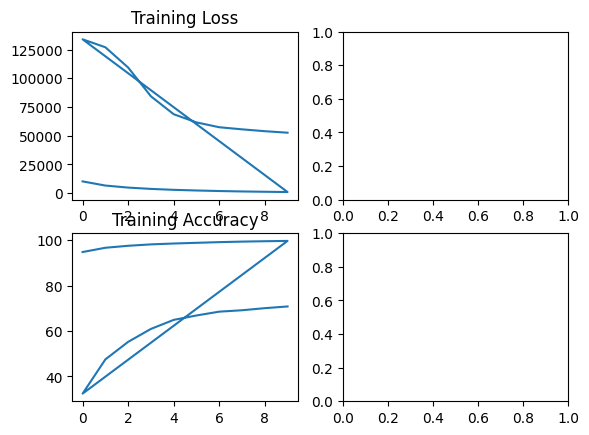

In [83]:

# generate graphs
model.graphs()

# model with rotations alone achieved 90.82 with speed 111.31 and loss 19302.602
# model with noise and rotations achieved 71.88% with speed 98.74 and loss 50869.420
# model train with normal and aug data achieved 70.84% with speed 98.04 and loss 52446.075

In [84]:

def getaccuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))
    
# test the model
total = 0.0
correct = 0.0

for data in testloader:
    # get the data
    inputs = data[0]
    labels = data[1]

    # make predictions
    output = predictionModel(inputs)

    _, predicted = torch.max(output.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total

print(accuracy)

# model with roations only got 90.81
# model with rotations and noise got 85.99
# model trained with normal and augmenteed data 86.25

86.25


In [85]:
import cv2
import os

# read list of test images
folder = './images/'
img_list =  os.listdir(folder)

# predict for each file
for image in img_list:
    file_path = folder + image

    test_image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

    # format Image
    # print(test_image.shape)
    img_resized = cv2.resize(test_image, (28, 28), interpolation=cv2.INTER_LINEAR)
    img_reversed = cv2.bitwise_not(img_resized)
    # cv2.imwrite(image,img_reversed)

    # flatten image for prediction
    reshape_img = np.reshape(img_reversed,(1,784))

    # convert test image to tensor for prediction
    tensor_reversed_img = torch.from_numpy(reshape_img)

    # make predictions
    output = predictionModel(tensor_reversed_img)
    _, predicted = torch.max(output.data, 1)
    print(f"\nImage: {file_path} \nPrediction: {predicted}")



Image: ./images/handwritten_four.jpg 
Prediction: tensor([3])

Image: ./images/handwritten_six.png 
Prediction: tensor([6])

Image: ./images/handwritten_three.png 
Prediction: tensor([3])
